Arm based on this paper:

https://www-spiedigitallibrary-org.tudelft.idm.oclc.org/journals/optical-engineering/volume-57/issue-04/043113/Comparison-of-multihardware-parallel-implementations-for-a-phase-unwrapping-algorithm/10.1117/1.OE.57.4.043113.full

Works also on LS but adds mechanism to minimize impact of residues
with this source:

https://codeocean.com/capsule/2672585/tree/v1

* insert credits
* explenation on implemetation of C code

Still need to insrt some weights based on the paper, to improve results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import math
import sys, os
import time
sys.path.append(os.path.abspath("..")) 

from scipy.fftpack import dctn, idctn

def additive_noise(phase, sigma, enabled=True):
    if enabled:
        noise = np.random.normal(0, sigma, size=phase.shape)
        return phase + noise
    return phase

# Optics
lam   = 0.532     # wavelength (µm)

from src.cylinder_phase import cylinder_phase_perp_to_z_3d

# Grid (µm/px)
Nx, Ny = 512, 512
px, py = 0.2, 0.2

# Material: either a scalar, a 2D array n(x,y), or a callable n_obj(X,Y,z)
n_obj = 1.38      # medium for cylinder
n_med = 1.33      # medium index
pz    = 0.2       # z step for integration (µm)   

# Activate for cylinder geometry

R = 20        # radius (µm)
L = 70.0          # axis length along x (µm); set None for infinite

phi_true, phi_wrapped, tissue_mask, medium_mask  = cylinder_phase_perp_to_z_3d(
    Nx, Ny, px, py,
    R, L,
    lam=lam, n_med=n_med,
    n_obj=n_obj,
    pz=pz
)

phi_wrapped_used = phi_wrapped

def additive_noise(phase, sigma, enabled=True):
    if enabled:
        noise = np.random.normal(0, sigma, size=phase.shape)
        return phase + noise
    return phase

ARM


In [2]:
import ctypes

dll_path = r"C:\Users\oheymans\odt-thesis\src\ARM\arm.dll"
lib = ctypes.CDLL(dll_path)

# Try to see if any "unwrap" function is in there
for name in dir(lib):
    if "unwrap" in name.lower():
        print(name)


ARM Rewrap consistency for wrapped_phase_0.tiff
NRMSE = 0.6432


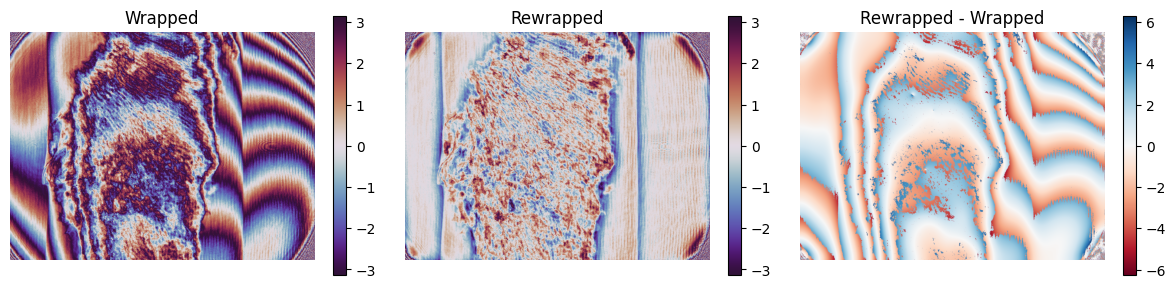

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.metrics import root_mean_squared_error

# ------------------------------------------------------
# Import ARM
# ------------------------------------------------------
from src.ARM.unwrap_arm import unwrap_phase_ARM

# ------------------------------------------------------
# Helpers
# ------------------------------------------------------
def rewrap(phi):
    """Wrap back into [-pi, pi)."""
    return np.angle(np.exp(1j * phi))

def evaluate_nrmse(phi_wrapped, phi_rewrapped, mask=None):
    """Compute normalized RMSE between wrapped and rewrapped."""
    if mask is None:
        mask = np.ones_like(phi_wrapped, dtype=bool)
    ref = phi_wrapped[mask]
    est = phi_rewrapped[mask]
    rmse = root_mean_squared_error(ref, est)
    denom = np.max(np.abs(ref))
    return rmse / (denom + 1e-8)

# ------------------------------------------------------
# Parameters
# ------------------------------------------------------
file_path = os.path.join("..", "data", "wrapped_phases", "wrapped_phase_0.tiff")
nIter = 10000
mu, lam, ban_OmegaInit = 1.0, 0.001, 0

if not os.path.exists(file_path):
    raise FileNotFoundError(f"No such file: {file_path}")

# ------------------------------------------------------
# Process single file
# ------------------------------------------------------
phi_wrapped = imread(file_path).astype(float)

# ARM unwrap
mask = np.ones_like(phi_wrapped, dtype=np.float64)
phi_unwrapped = unwrap_phase_ARM(
    phi_wrapped, mask=mask,
    mu=mu, lam=lam,
    nIter=nIter, ban_OmegaInit=ban_OmegaInit
)

# Rewrap
phi_rewrapped = rewrap(phi_unwrapped)

# Evaluate NRMSE
nrmse = evaluate_nrmse(phi_wrapped, phi_rewrapped)
print(f"\nARM Rewrap consistency for {os.path.basename(file_path)}")
print(f"NRMSE = {nrmse:.4f}")

# ------------------------------------------------------
# Plot results
# ------------------------------------------------------
diff = phi_rewrapped - phi_wrapped
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

im0 = axes[0].imshow(phi_wrapped, cmap="twilight_shifted", origin="lower")
axes[0].set_title("Wrapped")
plt.colorbar(im0, ax=axes[0], shrink=0.7)

im1 = axes[1].imshow(phi_rewrapped, cmap="twilight_shifted", origin="lower")
axes[1].set_title("Rewrapped")
plt.colorbar(im1, ax=axes[1], shrink=0.7)

im2 = axes[2].imshow(diff, cmap="RdBu", origin="lower")
axes[2].set_title("Rewrapped - Wrapped")
plt.colorbar(im2, ax=axes[2], shrink=0.7)

for ax in axes:
    ax.set_aspect("equal")
    ax.axis("off")

plt.tight_layout()
plt.show()


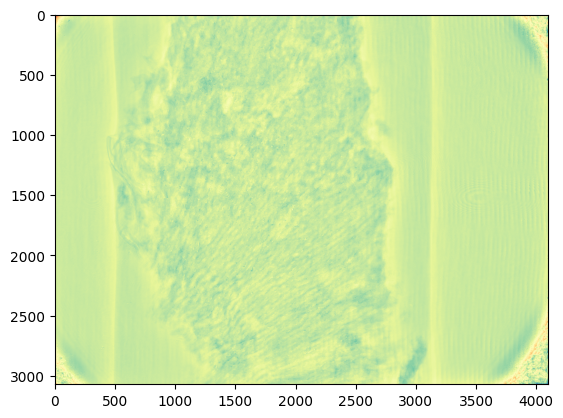

In [9]:
plt.imshow(phi_unwrapped, cmap="Spectral")
plt.show()

Evaluation of running time vs image size with a linear ramp

[1/36] N=192, repeat=1, time=5.598s | ETA: 3.27 min
[2/36] N=192, repeat=2, time=6.064s | ETA: 3.31 min
[3/36] N=192, repeat=3, time=5.911s | ETA: 3.22 min
[4/36] N=192, repeat=4, time=5.640s | ETA: 3.10 min
[5/36] N=192, repeat=5, time=5.506s | ETA: 2.97 min
[6/36] N=192, repeat=6, time=5.561s | ETA: 2.86 min
[7/36] N=284, repeat=1, time=12.279s | ETA: 3.22 min
[8/36] N=284, repeat=2, time=12.248s | ETA: 3.43 min
[9/36] N=284, repeat=3, time=12.882s | ETA: 3.59 min
[10/36] N=284, repeat=4, time=13.464s | ETA: 3.69 min
[11/36] N=284, repeat=5, time=13.879s | ETA: 3.75 min
[12/36] N=284, repeat=6, time=13.728s | ETA: 3.76 min
[13/36] N=512, repeat=1, time=50.462s | ETA: 4.81 min
[14/36] N=512, repeat=2, time=49.660s | ETA: 5.58 min
[15/36] N=512, repeat=3, time=47.565s | ETA: 6.08 min
[16/36] N=512, repeat=4, time=45.749s | ETA: 6.38 min
[17/36] N=512, repeat=5, time=45.387s | ETA: 6.55 min
[18/36] N=512, repeat=6, time=44.723s | ETA: 6.61 min
[19/36] N=1024, repeat=1, time=186.025s | E

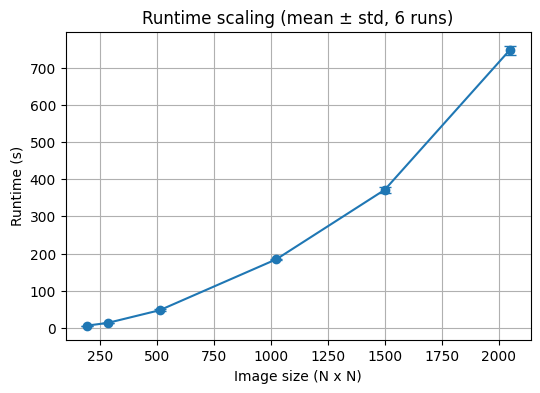

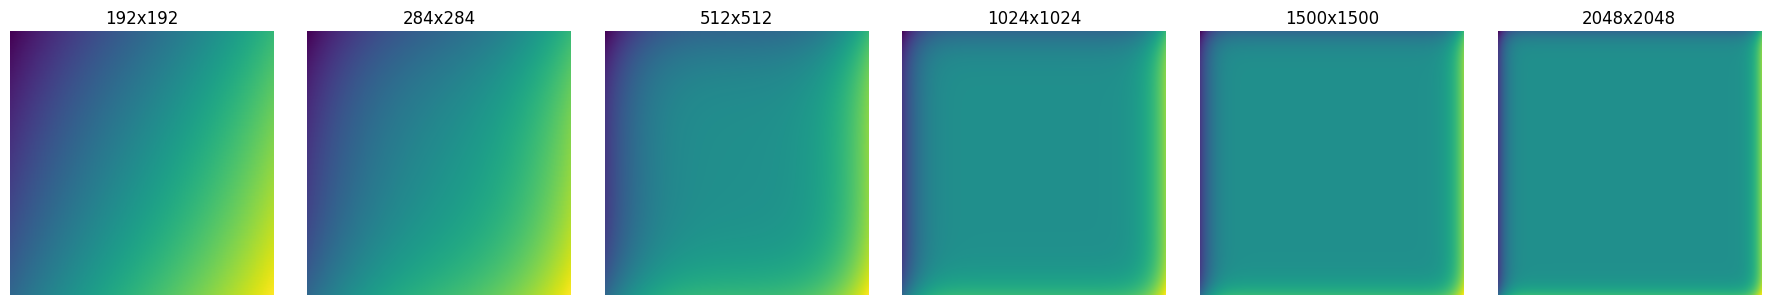

In [3]:
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))
from src.ARM.unwrap_arm import unwrap_phase_ARM
def make_ramp(Nx, Ny, px=1.0, py=1.0, slope_x=0.05, slope_y=0.0):
    x = (np.arange(Nx) - Nx/2) * px
    y = (np.arange(Ny) - Ny/2) * py
    X, Y = np.meshgrid(x, y, indexing="xy")
    phi_true = slope_x * X + slope_y * Y
    phi_wrap = np.angle(np.exp(1j * phi_true))
    return phi_true, phi_wrap

sizes = [192, 284, 512, 1024, 1500, 2048]
repeats = 6  # how many times per size

times_mean = []
times_std = []
unwrapped_results = {}

# --- progress tracking ---
total_jobs = len(sizes) * repeats
job_counter = 0
global_start = time.time()

for N in sizes:
    durations = []
    phi_true, phi_wrap = make_ramp(N, N, slope_x=0.1, slope_y=0.05)

    for r in range(repeats):
        job_counter += 1
        start = time.time()
        mask = np.ones_like(phi_wrap, dtype=np.float64)
        
        phi_unwrapped = unwrap_phase_ARM(
            phi_wrap, mask=mask,
            mu=1.0, lam=0.001,
            nIter=10000, ban_OmegaInit=0
            )
    

        end = time.time()
        durations.append(end - start)

        # progress update
        elapsed = time.time() - global_start
        avg_time = elapsed / job_counter
        remaining = (total_jobs - job_counter) * avg_time
        print(f"[{job_counter}/{total_jobs}] "
              f"N={N}, repeat={r+1}, time={end-start:.3f}s | "
              f"ETA: {remaining/60:.2f} min")

    unwrapped_results[N] = phi_unwrapped

    durations = np.array(durations)
    times_mean.append(durations.mean())
    times_std.append(durations.std())

# --- plot runtimes with error bars ---
plt.figure(figsize=(6,4))
plt.errorbar(sizes, times_mean, yerr=times_std, fmt="o-", capsize=4)
plt.xlabel("Image size (N x N)")
plt.ylabel("Runtime (s)")
plt.title(f"Runtime scaling (mean ± std, {repeats} runs)")
plt.grid(True)
plt.show()

# --- plot unwrapped phase side by side ---
fig, axs = plt.subplots(1, len(sizes), figsize=(3*len(sizes), 3))
for i, N in enumerate(sizes):
    axs[i].imshow(unwrapped_results[N], cmap="viridis")
    axs[i].set_title(f"{N}x{N}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()


Test unwrapping in different noise levels + statistics with comparison to reference

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.ARM.unwrap_arm import unwrap_phase_ARM

from sklearn.metrics import root_mean_squared_error

# ----------------------------------------------------------
# Noise levels to test
# ----------------------------------------------------------
noise_levels = [0.0, 0.2, 0.4, 0.6]
all_results_ARM = {}

for sigma in noise_levels:
    # Add noise to your *wrapped* phase
    phi_noisy = additive_noise(phi_wrapped, sigma, enabled=True)
    mask = np.ones_like(phi_noisy, dtype=np.float64)

    # Run ARM unwrapping
    phi_u_ARM = unwrap_phase_ARM(
        phi_noisy, mask=mask,
        mu=1.0, lam=0.001,
        nIter=10000, ban_OmegaInit=0
    )

    all_results_ARM[sigma] = (phi_noisy, phi_u_ARM)

# ----------------------------------------------------------
# Plot: ARM unwrapped phases
# ----------------------------------------------------------
all_unwrapped_global = np.concatenate([r.flatten() for (_, r) in all_results_ARM.values()])
vmin_u, vmax_u = np.min(all_unwrapped_global), np.max(all_unwrapped_global)

fig, axes = plt.subplots(len(noise_levels),1, figsize=(4, 4*len(noise_levels)))
for i, (sigma, (phi_noisy, phi_u)) in enumerate(all_results_ARM.items()):
    ax = axes[i]
    im = ax.imshow(phi_u, cmap="twilight_shifted", origin="lower", vmin=vmin_u, vmax=vmax_u)
    ax.set_title(f"ARM σ={sigma:.2f}")
    ax.set_aspect('equal')
    plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("ARM: Unwrapped Phase at Different Noise Levels", fontsize=14)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Plot: Error maps (vs true phase)
# ----------------------------------------------------------
all_errors_global = np.concatenate([(phi_u - phi_true).flatten() for (_, phi_u) in all_results_ARM.values()])
vmin_e, vmax_e = np.min(all_errors_global), np.max(all_errors_global)

fig, axes = plt.subplots(len(noise_levels), 1, figsize=(4, 4*len(noise_levels)))
for i, (sigma, (phi_noisy, phi_u)) in enumerate(all_results_ARM.items()):
    ax = axes[i]
    err = phi_u - phi_true
    im = ax.imshow(err, cmap="RdBu", origin="lower", vmin=vmin_e, vmax=vmax_e)
    ax.set_title(f"Error σ={sigma:.2f}")
    ax.set_aspect('equal')
    plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("ARM: Error Maps at Different Noise Levels", fontsize=14)
plt.tight_layout()
plt.show()


[1/28] Running ARM with σ=0.0, run 1/7...
[2/28] Running ARM with σ=0.0, run 2/7...
[3/28] Running ARM with σ=0.0, run 3/7...
[4/28] Running ARM with σ=0.0, run 4/7...
[5/28] Running ARM with σ=0.0, run 5/7...
[6/28] Running ARM with σ=0.0, run 6/7...
[7/28] Running ARM with σ=0.0, run 7/7...
[8/28] Running ARM with σ=0.2, run 1/7...
[9/28] Running ARM with σ=0.2, run 2/7...
[10/28] Running ARM with σ=0.2, run 3/7...
[11/28] Running ARM with σ=0.2, run 4/7...
[12/28] Running ARM with σ=0.2, run 5/7...
[13/28] Running ARM with σ=0.2, run 6/7...
[14/28] Running ARM with σ=0.2, run 7/7...
[15/28] Running ARM with σ=0.4, run 1/7...
[16/28] Running ARM with σ=0.4, run 2/7...
[17/28] Running ARM with σ=0.4, run 3/7...
[18/28] Running ARM with σ=0.4, run 4/7...
[19/28] Running ARM with σ=0.4, run 5/7...
[20/28] Running ARM with σ=0.4, run 6/7...
[21/28] Running ARM with σ=0.4, run 7/7...
[22/28] Running ARM with σ=0.6, run 1/7...
[23/28] Running ARM with σ=0.6, run 2/7...
[24/28] Running ARM 

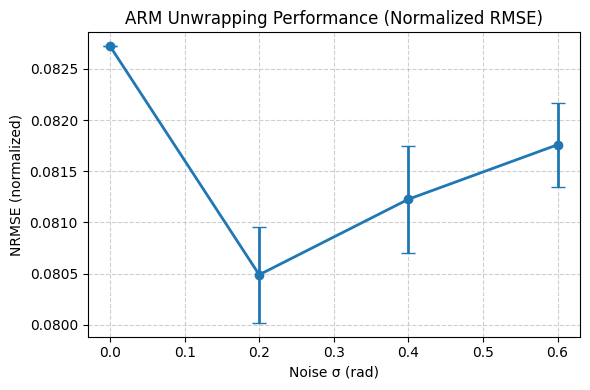

In [7]:
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

def evaluate_phase(phi_true, phi_unwrapped, mask=None):
    if mask is None:
        mask = np.ones_like(phi_true, dtype=bool)

    t = phi_true[mask]
    u = phi_unwrapped[mask]

    offset = np.mean(u - t)
    u_corr = u - offset

    rmse = root_mean_squared_error(t, u_corr)
    return rmse

# Make sure we can import from src/
sys.path.append(os.path.abspath(".."))

# ARM unwrapping
from src.ARM.unwrap_arm import unwrap_phase_ARM

# ------------------------------------------------------
# Fix dtype compatibility (needed for some unwrapping libs)
# ------------------------------------------------------
if not hasattr(np, "float_"): np.float_ = np.float64
if not hasattr(np, "int_"):   np.int_   = np.int64
if not hasattr(np, "bool_"):  np.bool_  = bool

# ------------------------------------------------------
# Parameters
# ------------------------------------------------------
noise_levels = [0.0, 0.2, 0.4, 0.6]   # radians
n_runs = 7

# Initialize results storage
rmse_results = {sigma: {"ARM": []} for sigma in noise_levels}

# ------------------------------------------------------
# Main loop with progress printing
# ------------------------------------------------------
total_loops = len(noise_levels) * n_runs
counter = 0

for sigma in noise_levels:
    for run in range(n_runs):
        counter += 1
        print(f"[{counter}/{total_loops}] Running ARM with σ={sigma}, run {run+1}/{n_runs}...")

        # Add noise to your *wrapped* phase
        phi_noisy = additive_noise(phi_wrapped, sigma, enabled=True)
        mask = np.ones_like(phi_noisy, dtype=np.float64)

        # Run ARM unwrapping
        phi_ARM = unwrap_phase_ARM(
            phi_noisy, mask=mask,
            mu=1.0, lam=0.001,
            nIter=10000, ban_OmegaInit=0
        )

        # Evaluate RMSE
        rmse = evaluate_phase(phi_true, phi_ARM, tissue_mask)
        rmse_results[sigma]["ARM"].append(rmse)

# ------------------------------------------------------
# Normalization factor
# ------------------------------------------------------
phi_max = np.max(np.abs(phi_true[tissue_mask]))  # reference max phase in radians
print(f"\nReference max phase (inside tissue) = {phi_max:.4f} rad")

# ------------------------------------------------------
# Report
# ------------------------------------------------------
print("\nARM: Mean NRMSE (7 runs each)")
means, stds = [], []
for sigma in noise_levels:
    vals = np.array(rmse_results[sigma]["ARM"])
    nrmse_vals = vals / phi_max
    mean_nrmse = np.mean(nrmse_vals)
    std_nrmse  = np.std(nrmse_vals)
    means.append(mean_nrmse)
    stds.append(std_nrmse)
    print(f"σ = {sigma:.2f} → NRMSE = {mean_nrmse:.4f} ± {std_nrmse:.4f}")

# ------------------------------------------------------
# Plot
# ------------------------------------------------------
plt.figure(figsize=(6,4))
plt.errorbar(noise_levels, means, yerr=stds, fmt='o-', capsize=5, lw=2, markersize=6)
plt.xlabel("Noise σ (rad)")
plt.ylabel("NRMSE (normalized)")
plt.title("ARM Unwrapping Performance (Normalized RMSE)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


RMSE vs number of iterations 

[1/50] Running ARM with nIter=500, run 1/10...
[2/50] Running ARM with nIter=500, run 2/10...
[3/50] Running ARM with nIter=500, run 3/10...
[4/50] Running ARM with nIter=500, run 4/10...
[5/50] Running ARM with nIter=500, run 5/10...
[6/50] Running ARM with nIter=500, run 6/10...
[7/50] Running ARM with nIter=500, run 7/10...
[8/50] Running ARM with nIter=500, run 8/10...
[9/50] Running ARM with nIter=500, run 9/10...
[10/50] Running ARM with nIter=500, run 10/10...
[11/50] Running ARM with nIter=1000, run 1/10...
[12/50] Running ARM with nIter=1000, run 2/10...
[13/50] Running ARM with nIter=1000, run 3/10...
[14/50] Running ARM with nIter=1000, run 4/10...
[15/50] Running ARM with nIter=1000, run 5/10...
[16/50] Running ARM with nIter=1000, run 6/10...
[17/50] Running ARM with nIter=1000, run 7/10...
[18/50] Running ARM with nIter=1000, run 8/10...
[19/50] Running ARM with nIter=1000, run 9/10...
[20/50] Running ARM with nIter=1000, run 10/10...
[21/50] Running ARM with nIter=5000, 

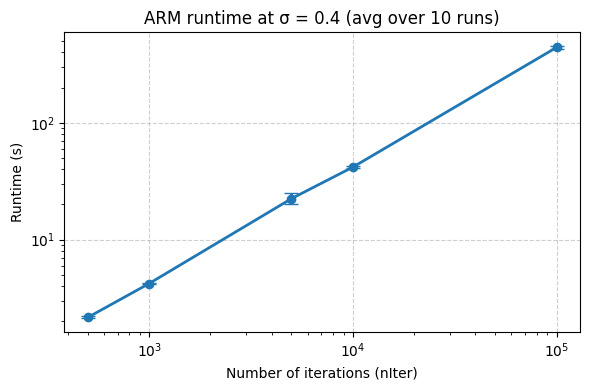

In [4]:
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt

# --- ARM import ---
sys.path.append(os.path.abspath(".."))
from src.ARM.unwrap_arm import unwrap_phase_ARM

# --- Fix dtype compatibility ---
if not hasattr(np, "float_"): np.float_ = np.float64
if not hasattr(np, "int_"):   np.int_   = np.int64
if not hasattr(np, "bool_"):  np.bool_  = bool

# ------------------------------------------------------
# Parameters
# ------------------------------------------------------
sigma = 0.4             # noise level
n_runs = 10             # number of repeats
iter_list = [500, 1000, 5000, 10000, 100000]

# Storage
time_iters = {nIter: [] for nIter in iter_list}

# ------------------------------------------------------
# Main loop
# ------------------------------------------------------
total_loops = len(iter_list) * n_runs
counter = 0

for nIter in iter_list:
    for run in range(n_runs):
        counter += 1
        print(f"[{counter}/{total_loops}] Running ARM with nIter={nIter}, run {run+1}/{n_runs}...")

        # Add noise
        phi_noisy = additive_noise(phi_wrapped, sigma, enabled=True)
        mask = np.ones_like(phi_noisy, dtype=np.float64)

        # Run ARM and measure time
        t0 = time.time()
        _ = unwrap_phase_ARM(
            phi_noisy, mask=mask,
            mu=1.0, lam=0.001,
            nIter=nIter, ban_OmegaInit=0
        )
        t1 = time.time()

        time_iters[nIter].append(t1 - t0)

# ------------------------------------------------------
# Report
# ------------------------------------------------------
print("\nARM: runtime vs iterations")
for nIter in iter_list:
    mean_time = np.mean(time_iters[nIter])
    std_time  = np.std(time_iters[nIter])
    print(f"nIter = {nIter:6d} → Time = {mean_time:.3f} ± {std_time:.3f} s")

# ------------------------------------------------------
# Plot runtime vs iterations
# ------------------------------------------------------
mean_times = [np.mean(time_iters[n]) for n in iter_list]
std_times  = [np.std(time_iters[n]) for n in iter_list]

plt.figure(figsize=(6,4))
plt.errorbar(iter_list, mean_times, yerr=std_times,
             fmt='o-', capsize=5, lw=2, markersize=6)
plt.xlabel("Number of iterations (nIter)")
plt.ylabel("Runtime (s)")
plt.title(f"ARM runtime at σ = {sigma} (avg over {n_runs} runs)")
plt.xscale("log")
plt.yscale("log")  # runtime usually ~linear in nIter
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


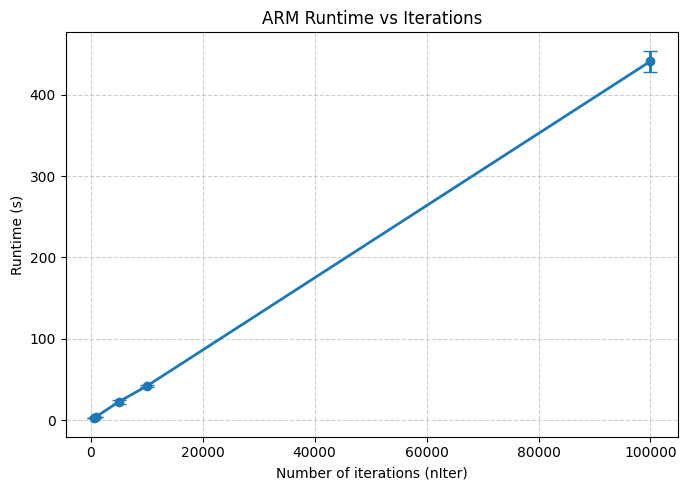

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your run
iter_list = [500, 1000, 5000, 10000, 100000]
mean_times = [2.158, 4.207, 22.430, 41.718, 441.481]
std_times  = [0.045, 0.035, 2.447, 0.972, 12.909]

# Plot
plt.figure(figsize=(7,5))
plt.errorbar(iter_list, mean_times, yerr=std_times,
             fmt='o-', capsize=5, lw=2, markersize=6)
plt.xlabel("Number of iterations (nIter)")
plt.ylabel("Runtime (s)")
plt.title("ARM Runtime vs Iterations")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


[1/25] Running ARM with nIter=500, run 1/5...
[2/25] Running ARM with nIter=500, run 2/5...
[3/25] Running ARM with nIter=500, run 3/5...
[4/25] Running ARM with nIter=500, run 4/5...
[5/25] Running ARM with nIter=500, run 5/5...
[6/25] Running ARM with nIter=1000, run 1/5...
[7/25] Running ARM with nIter=1000, run 2/5...
[8/25] Running ARM with nIter=1000, run 3/5...
[9/25] Running ARM with nIter=1000, run 4/5...
[10/25] Running ARM with nIter=1000, run 5/5...
[11/25] Running ARM with nIter=5000, run 1/5...
[12/25] Running ARM with nIter=5000, run 2/5...
[13/25] Running ARM with nIter=5000, run 3/5...
[14/25] Running ARM with nIter=5000, run 4/5...
[15/25] Running ARM with nIter=5000, run 5/5...
[16/25] Running ARM with nIter=10000, run 1/5...
[17/25] Running ARM with nIter=10000, run 2/5...
[18/25] Running ARM with nIter=10000, run 3/5...
[19/25] Running ARM with nIter=10000, run 4/5...
[20/25] Running ARM with nIter=10000, run 5/5...
[21/25] Running ARM with nIter=100000, run 1/5...

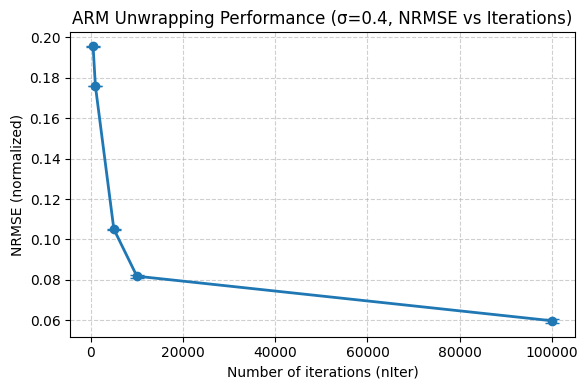

In [8]:
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

def evaluate_phase(phi_true, phi_unwrapped, mask=None):
    if mask is None:
        mask = np.ones_like(phi_true, dtype=bool)
    t = phi_true[mask]
    u = phi_unwrapped[mask]
    offset = np.mean(u - t)
    u_corr = u - offset
    rmse = root_mean_squared_error(t, u_corr)
    return rmse

# Make sure we can import from src/
sys.path.append(os.path.abspath(".."))
from src.ARM.unwrap_arm import unwrap_phase_ARM

# ------------------------------------------------------
# Fix dtype compatibility
# ------------------------------------------------------
if not hasattr(np, "float_"): np.float_ = np.float64
if not hasattr(np, "int_"):   np.int_   = np.int64
if not hasattr(np, "bool_"):  np.bool_  = bool

# ------------------------------------------------------
# Parameters
# ------------------------------------------------------
iter_list = [500, 1000, 5000, 10000, 100000]  # iteration counts
n_runs = 5
sigma = 0.4   # fix noise level

# Initialize results storage
rmse_results = {nIter: {"ARM": []} for nIter in iter_list}

# ------------------------------------------------------
# Main loop with progress printing
# ------------------------------------------------------
total_loops = len(iter_list) * n_runs
counter = 0

for nIter in iter_list:
    for run in range(n_runs):
        counter += 1
        print(f"[{counter}/{total_loops}] Running ARM with nIter={nIter}, run {run+1}/{n_runs}...")

        # Add noise
        phi_noisy = additive_noise(phi_wrapped, sigma, enabled=True)
        mask = np.ones_like(phi_noisy, dtype=np.float64)

        # Run ARM
        phi_ARM = unwrap_phase_ARM(
            phi_noisy, mask=mask,
            mu=1.0, lam=0.001,
            nIter=nIter, ban_OmegaInit=0
        )

        # Evaluate RMSE
        rmse = evaluate_phase(phi_true, phi_ARM, tissue_mask)
        rmse_results[nIter]["ARM"].append(rmse)

# ------------------------------------------------------
# Normalization factor
# ------------------------------------------------------
phi_max = np.max(np.abs(phi_true[tissue_mask]))  # reference max phase
print(f"\nReference max phase (inside tissue) = {phi_max:.4f} rad")

# ------------------------------------------------------
# Report
# ------------------------------------------------------
print("\nARM: Mean NRMSE vs iterations")
means, stds = [], []
for nIter in iter_list:
    vals = np.array(rmse_results[nIter]["ARM"])
    nrmse_vals = vals / phi_max
    mean_nrmse = np.mean(nrmse_vals)
    std_nrmse  = np.std(nrmse_vals)
    means.append(mean_nrmse)
    stds.append(std_nrmse)
    print(f"nIter = {nIter:6d} → NRMSE = {mean_nrmse:.4f} ± {std_nrmse:.4f}")

# ------------------------------------------------------
# Plot
# ------------------------------------------------------
plt.figure(figsize=(6,4))
plt.errorbar(iter_list, means, yerr=stds, fmt='o-', capsize=5, lw=2, markersize=6)
plt.xlabel("Number of iterations (nIter)")
plt.ylabel("NRMSE (normalized)")
plt.title(f"ARM Unwrapping Performance (σ={sigma}, NRMSE vs Iterations)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.metrics import root_mean_squared_error

# ------------------------------------------------------
# Import ARM
# ------------------------------------------------------
from src.ARM.unwrap_arm import unwrap_phase_ARM

# ------------------------------------------------------
# Helpers
# ------------------------------------------------------
def rewrap(phi):
    """Wrap back into [-pi, pi)."""
    return np.angle(np.exp(1j * phi))

def evaluate_nrmse(phi_wrapped, phi_rewrapped, mask=None):
    """Compute normalized RMSE between wrapped and rewrapped."""
    if mask is None:
        mask = np.ones_like(phi_wrapped, dtype=bool)
    ref = phi_wrapped[mask]
    est = phi_rewrapped[mask]
    rmse = root_mean_squared_error(ref, est)
    denom = np.max(np.abs(ref))
    return rmse / (denom + 1e-8)

# ------------------------------------------------------
# Parameters
# ------------------------------------------------------
# one level up from notebooks/
folder = os.path.join("..", "data", "wrapped_phases")
nIter = 10000
mu, lam, ban_OmegaInit = 1.0, 0.001, 0

# Collect files (handles .tif or .tiff)
files = sorted(glob.glob(os.path.join(folder, "wrapped_phase_*.tif*")))

if not files:
    raise FileNotFoundError(f"No TIFF files found in {folder}")

# ------------------------------------------------------
# Main loop with progress printing
# ------------------------------------------------------
nrmse_vals = []
rewrapped_maps = {}

total = len(files)
for idx, fname in enumerate(files, start=1):
    print(f"[{idx}/{total}] Processing {os.path.basename(fname)} ...")

    phi_wrapped = imread(fname).astype(float)

    # ARM unwrap
    mask = np.ones_like(phi_wrapped, dtype=np.float64)
    phi_unwrapped = unwrap_phase_ARM(
        phi_wrapped, mask=mask,
        mu=mu, lam=lam,
        nIter=nIter, ban_OmegaInit=ban_OmegaInit
    )

    # Rewrap
    phi_rewrapped = rewrap(phi_unwrapped)

    # Evaluate NRMSE
    nrmse = evaluate_nrmse(phi_wrapped, phi_rewrapped)
    nrmse_vals.append(nrmse)

    # Store a few results for plotting
    if idx in [1, 6, 11]:  # pick some examples by index
        rewrapped_maps[idx] = (phi_wrapped, phi_rewrapped, phi_rewrapped - phi_wrapped)

# ------------------------------------------------------
# Report
# ------------------------------------------------------
mean_nrmse = np.mean(nrmse_vals)
std_nrmse = np.std(nrmse_vals)
print(f"\nARM Rewrap consistency (N={len(files)} images)")
print(f"NRMSE = {mean_nrmse:.4f} ± {std_nrmse:.4f}")

# ------------------------------------------------------
# Plot examples
# ------------------------------------------------------
for idx, (phi_w, phi_rw, diff) in rewrapped_maps.items():
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    im0 = axes[0].imshow(phi_w, cmap="twilight_shifted", origin="lower")
    axes[0].set_title(f"Wrapped (file {idx})")
    plt.colorbar(im0, ax=axes[0], shrink=0.7)

    im1 = axes[1].imshow(phi_rw, cmap="twilight_shifted", origin="lower")
    axes[1].set_title("Rewrapped")
    plt.colorbar(im1, ax=axes[1], shrink=0.7)

    im2 = axes[2].imshow(diff, cmap="RdBu", origin="lower")
    axes[2].set_title("Rewrapped - Wrapped")
    plt.colorbar(im2, ax=axes[2], shrink=0.7)

    for ax in axes:
        ax.set_aspect("equal")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


[1/15] Processing wrapped_phase_0.tiff ...
[2/15] Processing wrapped_phase_1.tiff ...


In [ ]:

import os
import numpy as np
from skimage.io import imread
from sklearn.metrics import root_mean_squared_error
from skimage.restoration import unwrap_phase
import matplotlib.pyplot as plt

# ------------------------------------------------------
# Imports from your repo
# ------------------------------------------------------
import sys
sys.path.append(os.path.abspath("..")) 

from src.Ghilia.Ghilia import unwrap_phase_weighted
from src.Ghilia.reliability import reliability_weight_map


# Fix dtype compatibility
if not hasattr(np, "float_"):
    np.float_ = np.float64
if not hasattr(np, "int_"):
    np.int_ = np.int64
if not hasattr(np, "bool_"):
    np.bool_ = bool

from kamui import unwrap_dimensional
# ------------------------------------------------------
# Helpers
# ------------------------------------------------------
def wrap_phase(phase):
    """Wrap phase into [-pi, pi)."""
    return np.angle(np.exp(1j * phase))

def evaluate_nrmse(phi_wrapped, phi_rewrapped, mask=None):
    """Compute normalized RMSE between wrapped and rewrapped phases."""
    if mask is None:
        mask = np.ones_like(phi_wrapped, dtype=bool)
    ref = phi_wrapped[mask]
    est = phi_rewrapped[mask]
    rmse = root_mean_squared_error(ref, est)
    denom = np.max(np.abs(ref))
    return rmse / (denom + 1e-8)

# ------------------------------------------------------
# Parameters
# ------------------------------------------------------
folder = os.path.join("..", "data", "wrapped_phases")
methods = ["Sorting by reliability", "UnWeighted LS", "Weighted LS", "Network programming"]

# Collect TIFF files
files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith((".tif", ".tiff"))]
files = sorted(files)

if not files:
    raise FileNotFoundError(f"No .tif/.tiff files found in {folder}")

# ------------------------------------------------------
# Use only the first file
# ------------------------------------------------------
fname = files[0]
print(f"Processing single file: {os.path.basename(fname)}")
phi_wrapped = imread(fname).astype(float)

# Precompute weights
weights = reliability_weight_map(phi_wrapped)
weights_masked = weights

# ------------------------------------------------------
# Run methods
# ------------------------------------------------------
nrmse_results = {}

# Sorting by reliability (SciPy unwrap)
phi_scipy = unwrap_phase(phi_wrapped)
phi_scipy_re = wrap_phase(phi_scipy)
nrmse_results["Sorting by reliability"] = evaluate_nrmse(phi_wrapped, phi_scipy_re)

# UnWeighted LS
phi_ls = unwrap_phase_weighted(phi_wrapped)
phi_ls_re = wrap_phase(phi_ls)
nrmse_results["UnWeighted LS"] = evaluate_nrmse(phi_wrapped, phi_ls_re)

# Weighted LS
phi_weight = unwrap_phase_weighted(phi_wrapped, weights_masked)
phi_weight_re = wrap_phase(phi_weight)
nrmse_results["Weighted LS"] = evaluate_nrmse(phi_wrapped, phi_weight_re)

# Network programming (Kamui)
phi_kamui = unwrap_dimensional(phi_wrapped)
phi_kamui_re = wrap_phase(phi_kamui)
nrmse_results["Network programming"] = evaluate_nrmse(phi_wrapped, phi_kamui_re)

# ------------------------------------------------------
# Report
# ------------------------------------------------------
print("\nNRMSE for single image:")
for m, val in nrmse_results.items():
    print(f"{m:25s}: {val:.4f}")


Processing single file: wrapped_phase_0.tiff
